In [41]:
import pandas as pd 

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [43]:
# drop identifiers 
X_train = train.drop(columns=['TARGET_RENT_5YR', 'AREA_NAME', 'YEAR'])
y_train = train['TARGET_RENT_5YR']

X_test = test.drop(columns=['TARGET_RENT_5YR', 'AREA_NAME', 'YEAR'])
y_test = test['TARGET_RENT_5YR']

print(f"Features used for training: {list(X_train.columns)}")


Features used for training: ['1_bedrooms_leased', '2_bedrooms_avg_lease_rate', 'area_sq_meters', 'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters', 'transit_line_density', 'distinct_route_count', 'avg_rent_1br', 'rent_lag_1', 'rent_lag_2', 'rent_growth_rate', 'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE', 'is_missing_AUTOTHEFT_RATE', 'years_since_baseline']


In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# initalize
model = XGBRegressor(
    n_estimators=100,                  
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42)
# train the model
model.fit(X_train, y_train)

# predictions 
predictions = model.predict(X_test)

In [46]:
# MAE of ~$274  
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Features only explain ~25% percent of rent changes. Model is severely underperfroming 
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.5f}")

# Compare actual vs predicted for the first 5 rows
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print("\n10 Predictions:")
print(comparison.head(10))

MAE: $279.80
R² Score: 0.20921

10 Predictions:
        Actual    Predicted
0  2464.500000  2264.559814
1  2220.000000  2392.928467
2  2464.500000  2262.925781
3  2220.000000  2391.294678
4  3092.166667  2879.612305
5  2448.000000  2774.951172
6  4414.833333  2926.333252
7  2665.000000  2697.095459
8  2878.833333  2651.579834
9  2379.000000  2681.443604


In [ ]:
# Create  correlation matrix 
import numpy as np 

train_num = train.select_dtypes(include=[np.number])
m_corr = train_num.corr()
# See how everything correlates specifically with the target rent
print("m_corr with TARGET_RENT_5YR:")
print(m_corr["TARGET_RENT_5YR"].sort_values(ascending=False))

m_corr with TARGET_RENT_5YR:
TARGET_RENT_5YR              1.000000
avg_rent_1br                 0.821866
rent_lag_1                   0.801691
2_bedrooms_avg_lease_rate    0.699486
rent_lag_2                   0.689285
years_since_baseline         0.453319
YEAR                         0.453319
THEFTOVER_RATE               0.176293
rent_growth_rate             0.135135
ASSAULT_RATE                 0.086752
1_bedrooms_leased            0.075366
avg_stop_frequency           0.071348
ROBBERY_RATE                 0.020392
is_missing_THEFTOVER_RATE    0.018652
park_count                   0.000475
is_missing_ROBBERY_RATE     -0.001170
max_stop_frequency          -0.017290
POPULATION                  -0.044912
is_missing_AUTOTHEFT_RATE   -0.051894
AUTOTHEFT_RATE              -0.119762
transit_line_density        -0.124523
total_line_length_meters    -0.124596
distinct_route_count        -0.159539
perimeter_meters            -0.164329
total_stop_count            -0.181990
area_sq_meters       

In [48]:
# 1. Add the new feature to the source dataframes
train['rent_velocity'] = train['avg_rent_1br'] - train['rent_lag_1']
test['rent_velocity'] = test['avg_rent_1br'] - test['rent_lag_1']

# re extract X_train and X_test so they include 'rent_velocity'
X_train = train.drop(columns=['TARGET_RENT_5YR', 'AREA_NAME', 'YEAR'])
X_test = test.drop(columns=['TARGET_RENT_5YR', 'AREA_NAME', 'YEAR'])

# now filter using the high correlation list
high_corr_features = ['avg_rent_1br', 'rent_lag_1', '2_bedrooms_avg_lease_rate', 
                     'rent_lag_2', 'years_since_baseline', 'rent_velocity']

X_train_filtered = X_train[high_corr_features]
X_test_filtered = X_test[high_corr_features]

# retrain the model on the filtered features
model.fit(X_train_filtered, y_train)
predictions = model.predict(X_test_filtered)


New MAE: $243.46
New R² Score: 0.29770


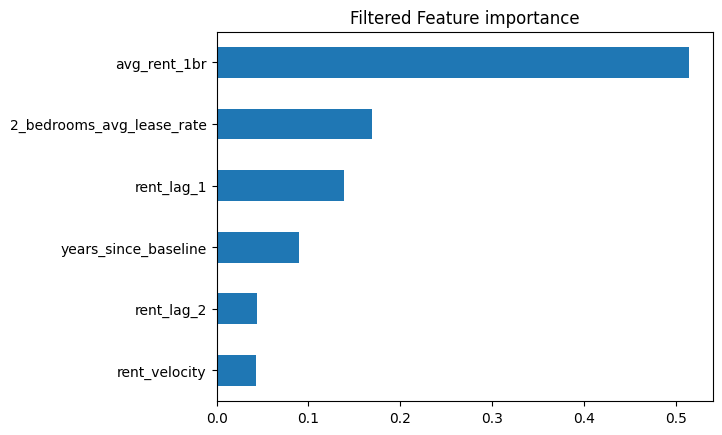

In [49]:
# Calculate new metrics
new_mae = mean_absolute_error(y_test, predictions)
new_r2 = r2_score(y_test, predictions)

print(f"New MAE: ${new_mae:.2f}")
print(f"New R² Score: {new_r2:.5f}")

# Check which of the filtered features is most dominant
import matplotlib.pyplot as plt
feat_importances = pd.Series(model.feature_importances_, index=high_corr_features)
feat_importances.sort_values().plot(kind='barh')
plt.title("Filtered Feature importance")
plt.show()

# siightly better MAE from focusing on more important features 

# Improvement Suggestions (no data manipulation)
- Growth multiplier, that converts into dollars for final output. 
    - Predict Ratio instead of dollar count (detrending) this works better in desicion trees 
- Time series split (if test set data is noticeably different than training)
- Visualizing Bias with matplotlib to account for neighborhood bias 
- Try Random Forest with shallow height to account for smaller row count 

- Biggest issue BY FAR is the predictions on luxury/high end units because they are seen as anomalies. Model completeley hiccups on these few listings. 
    - Log transformation, and predicting a growth ratio instead of a price increase, did not do much in terms of accuracy. 
    
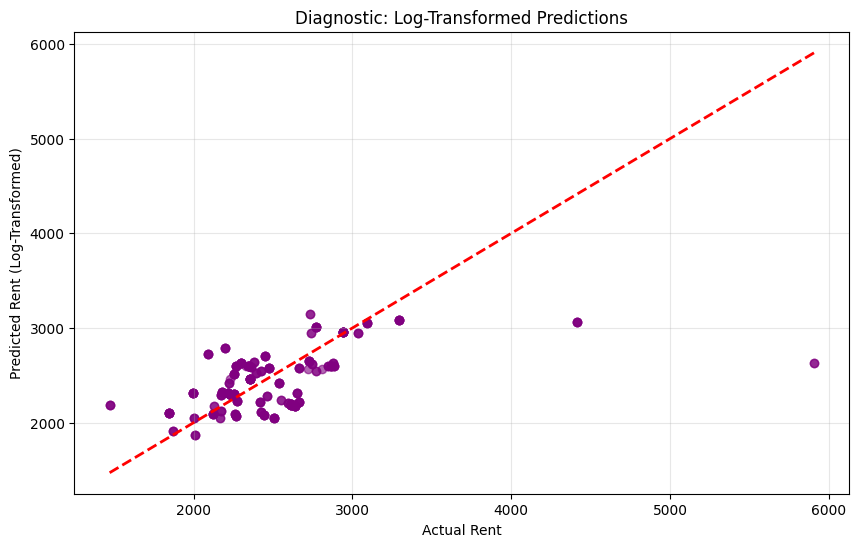

# Improvement Suggestions (Data Manipulation)

- Train on quarterly data for more rows
    - Factors that make quarterly data relevant: student, professional moves
- 3_bedrooms_avg_lease_rate should be trained, despite the gaps. Price signals in larger units sometimes indicate neighborhood prestige. 
- Bring back 2010-2013, column loss is more important than missing crime data - especially becasue it doesn't score high in corellation 
    - binary indicator crime_missing to account for gap 
- Column Reduction, especially in crime/transit. I assume that correlation goes up if we use these cols to create a safety score. 158 rows, and 20+ cols makes xg likely to overfit 

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor

# 1. Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],      # ntrees
    'max_depth': [3, 4, 5, 6],            # depth
    'learning_rate': [0.01, 0.05, 0.1],   # step size 
    'subsample': [0.7, 0.8, 1.0],      
    'colsample_bytree': [0.7, 0.8, 1.0]   
}

#  Cross-Validation
# splitting data into 5 parts ensures the result is robust, not just lucky
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:absoluteerror'),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=kfold,
    verbose=1,
    n_jobs=-1 
)

print("Starting Grid Search...")
grid_search.fit(X_train_filtered, y_train)

# 5. Get the best results
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# 6. Predict with the best model
tuned_predictions = best_model.predict(X_test_filtered)

# 7. Evaluate
tuned_mae = mean_absolute_error(y_test, tuned_predictions)
tuned_r2 = r2_score(y_test, tuned_predictions)

print(f" MAE: ${tuned_mae:.2f}")
print(f" R²: {tuned_r2:.5f}")